To run this script locally, the following files need to be copied to local:
- `/cbica/projects/clinical_dmri_benchmark/results/overlap/GQIautotrack_overlap.csv`
- `/cbica/projects/clinical_dmri_benchmark/results/overlap/CSDautotrack_overlap.csv`
- `/cbica/projects/clinical_dmri_benchmark/results/overlap/SS3Tautotrack_overlap.csv`

These are the outputs of the following scripts:
- `clinical_dmri_benchmark/analysis/overlap/sensitivity_specificity.sh`

In [1]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl

In [ ]:
# Read sensitivity-specificity csv and excluded subjects
OVERLAP_ROOT = "/Users/amelie/Datasets/clinical_dmri_benchmark/overlap"

ss3t_df = pd.read_csv(f"{OVERLAP_ROOT}/SS3Tautotrack_overlap.csv")
csd_df = pd.read_csv(f"{OVERLAP_ROOT}/CSDautotrack_overlap.csv")
gqi_df = pd.read_csv(f"{OVERLAP_ROOT}/GQIautotrack_overlap.csv")
with open("../data_processing/subject_lists/excluded_subjects.txt", "r") as f:
    excluded_subjects = [line.strip() for line in f]

# Filter excluded subjects from DataFrames
gqi_df = gqi_df[~gqi_df["subject_id"].isin(excluded_subjects)]
csd_df = csd_df[~csd_df["subject_id"].isin(excluded_subjects)]
ss3t_df = ss3t_df[~ss3t_df["subject_id"].isin(excluded_subjects)]

# Keep results only if the bundle for the considered subject and scan was reconstructed for all three methods
for df in [ss3t_df, csd_df, gqi_df]:
    df["subject_run_bundle"] = df["subject_id"].astype(
        str) + "-" + df["run"] + "-" + df["bundle"]

keys_ss3t = set(ss3t_df["subject_run_bundle"].unique())
keys_csd = set(csd_df["subject_run_bundle"].unique())
keys_gqi = set(gqi_df["subject_run_bundle"].unique())
common_keys = keys_ss3t & keys_csd & keys_gqi

ss3t_df = ss3t_df[ss3t_df["subject_run_bundle"].isin(common_keys)]
csd_df = csd_df[csd_df["subject_run_bundle"].isin(common_keys)]
gqi_df = gqi_df[gqi_df["subject_run_bundle"].isin(common_keys)]

ss3t_df["method"] = "SS3T"
csd_df["method"] = "CSD"
gqi_df["method"] = "GQI"


bundle_file = "../../data/bundle_names.txt"
with open(bundle_file, 'r') as f:
    bundles = [line.strip() for line in f.readlines()]

df_all = pd.concat([ss3t_df, csd_df, gqi_df], ignore_index=True)

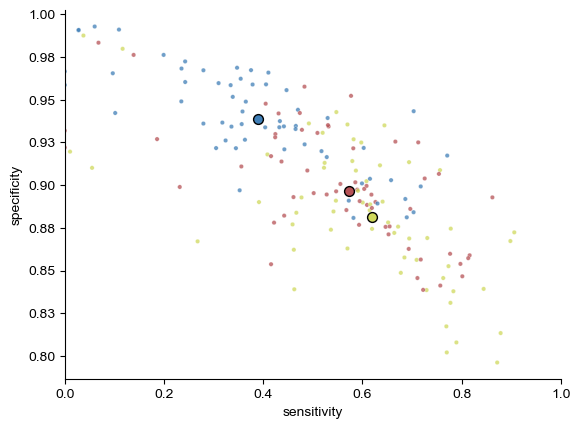

In [ ]:
# Create plot with the median values per bundle + the overall median values
my_palette = sns.color_palette(
    [(64/255, 127/255, 183/255), (208/255, 217/255, 92/255), (182/255, 82/255, 86/255)])
sns.set_palette(my_palette)
mpl.rcParams["font.family"] = "Arial"

median_values = df_all.groupby(["bundle", "method"])[
    ["sensitivity", "specificity"]].median().reset_index()
sns.scatterplot(data=median_values, x="sensitivity", y="specificity", hue="method", hue_order=[
                "GQI", "CSD", "SS3T"], s=10, alpha=0.75, palette=my_palette, legend=False)
overall_medians = median_values.groupby(
    "method")[["sensitivity", "specificity"]].median().reset_index()
sns.scatterplot(x=[gqi_df["sensitivity"].median()], y=[gqi_df["specificity"].median(
)], label="GQI median", edgecolor="black", linewidth=1, s=50, color=my_palette[0], legend=False)
sns.scatterplot(x=[csd_df["sensitivity"].median()], y=[csd_df["specificity"].median(
)], label="CSD median", edgecolor="black", linewidth=1, s=50, color=my_palette[1], legend=False)
sns.scatterplot(x=[ss3t_df["sensitivity"].median()], y=[ss3t_df["specificity"].median(
)], label="SS3T median", edgecolor="black", linewidth=1, s=50, color=my_palette[2], legend=False)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.xlim(0, 1)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.savefig("../../figures/sensitivity_specificity_all_bundles.svg")
plt.show()

In [ ]:
# Create plots for each bundle separately with the sensitivity-specificity pairs for all reconstructions of this bundle
# plus the median sensitivity + specificity pair per ODF reconstruction method
for bundle in bundles:
    ss3t_df_bundle = df_all[(df_all["method"] == "SS3T")
                            & (df_all["bundle"] == bundle)]
    csd_df_bundle = df_all[(df_all["method"] == "CSD")
                           & (df_all["bundle"] == bundle)]
    gqi_df_bundle = df_all[(df_all["method"] == "GQI")
                           & (df_all["bundle"] == bundle)]

    sns.scatterplot(data=gqi_df_bundle, x="sensitivity",
                    y="specificity", label="GQI", s=2, legend=False)
    sns.scatterplot(data=csd_df_bundle, x="sensitivity",
                    y="specificity", label="CSD", s=2, legend=False)
    sns.scatterplot(data=ss3t_df_bundle, x="sensitivity",
                    y="specificity", label="SS3T", s=2, legend=False)

    sns.scatterplot(x=[gqi_df_bundle["sensitivity"].median()], y=[
                    gqi_df_bundle["specificity"].median()], edgecolor="black", linewidth=1, label="GQI median", s=50, color=my_palette[0], legend=False)
    sns.scatterplot(x=[csd_df_bundle["sensitivity"].median()], y=[
                    csd_df_bundle["specificity"].median()], edgecolor="black", linewidth=1, label="CSD median", s=50, color=my_palette[1], legend=False)
    sns.scatterplot(x=[ss3t_df_bundle["sensitivity"].median()], y=[
                    ss3t_df_bundle["specificity"].median()], edgecolor="black", linewidth=1, label="SS3T median", s=50, color=my_palette[2], legend=False)
    
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.gca().spines['left'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)

    # These 60 files are saved outside of the Github repro
    plt.savefig(f"{OVERLAP_ROOT}/{bundle.split("_")[1]}.png", dpi=400)
    plt.clf()